In [1]:
import argparse, itertools, math, os, random, PIL
import numpy as np, torch.nn.functional as F, torch.utils.checkpoint
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed

from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from PIL import Image
from PIL.Image import Resampling
from torchvision import transforms
from tqdm.auto import tqdm

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
import fastcore.all as fc
from huggingface_hub import notebook_login
from pathlib import Path

import torchvision.transforms.functional as tf
import accelerate

/home/agastya/mambaforge/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
torch.manual_seed(1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
current_device = torch.cuda.current_device(), torch.cuda.get_device_name()
current_device, torch.cuda.device_count() 

((0, 'NVIDIA GeForce RTX 3060 Laptop GPU'), 1)

In [4]:
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [5]:
!cd ~ && ls

downloads  file.txt  git  mambaforge  nbs  personal


In [6]:
model_nm = "CompVis/stable-diffusion-v1-4"
path = Path.cwd()/'textual_inversion_photos'
paths = list(path.iterdir())
paths

[Path('/home/agastya/nbs/FastAI-course/Course Part 2-StableDiffusion/textual_inversion_photos/IMG_20240422_183842920.jpg')]

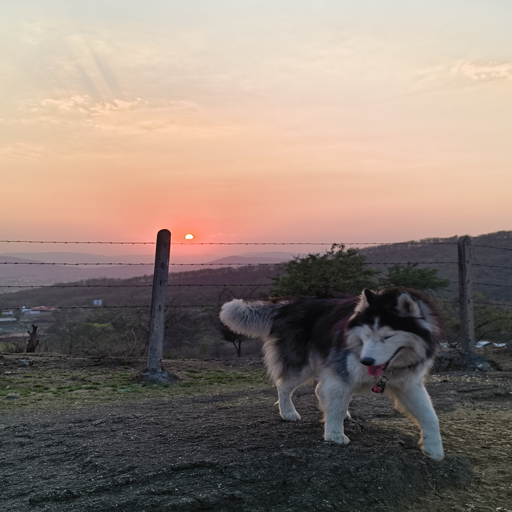

In [7]:
images = [Image.open(p).resize((512,512), resample=Resampling.BICUBIC).convert('RGB') for p in paths]
images[0]

In [8]:
what_to_teach = "object"
placeholder_token = "<tiny>"
initializer_token = "teddy"

In [9]:
templates = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [10]:
class TextualInversionDataset:
    def __init__(self, tokenizer, images, learnable_property="object", size=512,
                 repeats=100, interpolation=Resampling.BICUBIC, flip_p=0.5, set="train", placeholder_token="*"):
        fc.store_attr()
        self.num_images = len(images)
        if set == "train": self._length = self.num_images * repeats
        self.templates = style_templates if learnable_property == "style" else templates
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self): return self.num_images

    def __getitem__(self, i):
        image = tf.to_tensor(self.images[i%self.num_images])*2-1
        text = random.choice(self.templates).format(self.placeholder_token)
        ids=self.tokenizer(text, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt")
        return dict(input_ids=ids.input_ids[0], pixel_values=image)

tokenizer = CLIPTokenizer.from_pretrained(model_nm, subfolder="tokenizer")
num_added_tokens = tokenizer.add_tokens(placeholder_token)
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

text_encoder = CLIPTextModel.from_pretrained(model_nm, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_nm, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_nm, subfolder="unet")
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Freeze all parameters except for the token embeddings in text encoder
tm = text_encoder.text_model
for o in (vae, unet, tm.encoder, tm.final_layer_norm, tm.embeddings.position_embedding):
    for p in o.parameters(): p.requires_grad = False

train_dataset = TextualInversionDataset(
    images=images, tokenizer=tokenizer, size=512, placeholder_token=placeholder_token,
    repeats=10, learnable_property=what_to_teach, set="train")

def create_dataloader(bs=1): return DataLoader(train_dataset, batch_size=bs, shuffle=True)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

/home/agastya/mambaforge/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [11]:
accelerator = Accelerator(gradient_accumulation_steps=4, mixed_precision='fp16')
accelerator.device

device(type='cuda')

In [12]:
def training_function(text_encoder, vae, unet, train_batch_size, gradient_accumulation_steps,
                      lr, max_train_steps, scale_lr, output_dir):
    accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps, mixed_precision='fp16')
    train_dataloader = create_dataloader(train_batch_size)
    if scale_lr: lr = (lr * gradient_accumulation_steps * train_batch_size * accelerator.num_processes)
    optimizer = torch.optim.AdamW(text_encoder.get_input_embeddings().parameters(), lr=lr)
    text_encoder, optimizer, train_dataloader = accelerator.prepare(text_encoder, optimizer, train_dataloader)
    vae.to(accelerator.device).eval()
    unet.to(accelerator.device).eval()

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach() * 0.18215
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # We only want to optimize the concept embeddings
                grads = text_encoder.get_input_embeddings().weight.grad
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            progress_bar.set_postfix(loss=loss.detach().item())
            if global_step >= max_train_steps: break

    pipeline = StableDiffusionPipeline(
        text_encoder=accelerator.unwrap_model(text_encoder),
        vae=vae, unet=unet, tokenizer=tokenizer,
        scheduler=PNDMScheduler(
            beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True),
        safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
        feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))
    pipeline.save_pretrained(output_dir)
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

torch.manual_seed(42)
training_function(text_encoder, vae, unet, train_batch_size=1, gradient_accumulation_steps=6, lr=5e-04,
      max_train_steps=3000, scale_lr=True, output_dir="sd-concept-output")

  0%|          | 0/3000 [00:00<?, ?it/s]

/home/agastya/mambaforge/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 5.31 GiB is allocated by PyTorch, and 17.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)